In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from glob import glob
import os
import re
import pyemma.msm as msm
import pyemma.coordinates as coor
import pyemma.plots as mplt
import numpy as np
import my_network_plot as myplt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import operator
import pandas as pd
import mdtraj as md
import matplotlib.image as mpimg 


/Users/robertarbon/miniconda3/envs/science/lib/python3.6/site-packages/pyemma/util/log.py:64: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f2)


# Load the data

Below is the parameters cell for papermill parameterisation:

In [3]:
traj_num = 3
root_dir = 'msm_10ps'
slice_nums = [(2, 255), (4, 821), (3, 932)]
slice_num = 0


The paths to the relevant objects

In [4]:
data_dir = root_dir+'/output_{}'.format(traj_num)
msm_paths = [os.path.join(data_dir, '{}_msm_obj.pyemma'.format(i)) for _, i in slice_nums]
dtraj_paths = [os.path.join(data_dir, '{}_dtraj.npy'.format(i)) for _, i in slice_nums]


### MSMs


In [5]:
msms = [msm.MaximumLikelihoodMSM().load(x) for x in msm_paths]

/Users/robertarbon/miniconda3/envs/science/lib/python3.6/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


This is the conversion between lag in frames (which the MSM object keeps) and the time in ps. 

In [6]:
lag = msms[0].lagtime
dt = np.round(10/lag, 2)
dt 

0.10000000000000001

### Discrete trajectories

In [7]:
dtrajs = [np.load(x) for x in dtraj_paths]

## Models

In [8]:
msms  = [msm.estimate_markov_model(dtrajs[i], lag=lag) for i in range(len(slice_nums))]

In [9]:
bmsms  = [msm.bayesian_markov_model(dtrajs[i], lag=lag,  
                                          nsamples=1000) for i in range(len(slice_nums))]


In [10]:
bhmms = [msm.bayesian_hidden_markov_model(dtrajs[i], lag=lag, nstates=slice_nums[i][0], 
                                          nsamples=1000) for i in range(len(slice_nums))]

    

/Users/robertarbon/miniconda3/envs/science/lib/python3.6/site-packages/msmtools/analysis/dense/pcca.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


In [11]:
hmms = [msm.estimate_hidden_markov_model(dtrajs[i], lag=lag, nstates=slice_nums[i][0]) for i in range(len(slice_nums))]



In [12]:
tss = [mm.sample_conf('timescales')[1]*dt for mm in bhmms]
tss

[array([ 2029.20570767]),
 array([ 5512.94840109,   480.5215118 ,   255.51505402]),
 array([ 6866.43242032,   669.5963688 ])]

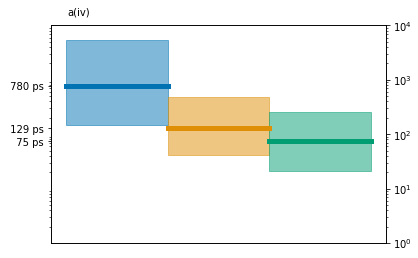

In [45]:
def plot_timescales(axes,  mm, dt, let, maxy=4388):
    
    ax = axes
    # Timescale plots
    ts = mm.sample_mean('timescales')*dt
    tsL,tsR = mm.sample_conf('timescales')
    tsL, tsR = tsL*dt, tsR*dt
    N = mm.nstates
    maxy = 10**(int(np.log10(maxy))+1)
    # Slow:
#     ax.plot(ts[0], 0, 1, lw=5, color='g', label='Slow')
    cols = sns.color_palette('colorblind', N-1)
    for i in range(0,N-1): 
        y = np.repeat(ts[i], 2)
        yl = np.repeat(tsL[i], 2)
        yr = np.repeat(tsR[i], 2)
        
        x = np.array([0, 1])+i
        ax.plot(x, y, lw=5, color=cols[i])
        ax.fill_between(x, yl, yr, color=cols[i], alpha=0.5)


    # Labels
    ax.set_yscale('log')
#     ax.set_ylabel('Timescales (ps)')
    
    # Tick marks for timescale plots
    locator = matplotlib.ticker.FixedLocator(locs=ts[:N], nbins=N)
    formatter = matplotlib.ticker.StrMethodFormatter('{x:4.0f} ps')
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_locator(locator)
    ax.tick_params(which='minor', labelleft=False, left=False)
    ax.tick_params(which='major', labelbottom = False, bottom=False)
    ax.set_ylim(1, maxy)
    ax2 = ax.twinx()
    ax2.set_ylim(1, maxy)
    ax2.set_yscale('log')
    ax.annotate(s='{}(iv)'.format(let), xy=(0.05, 1.05), xycoords='axes fraction')

    
fig, ax = plt.subplots()
plot_timescales(ax, bhmms[1], dt, 'a')

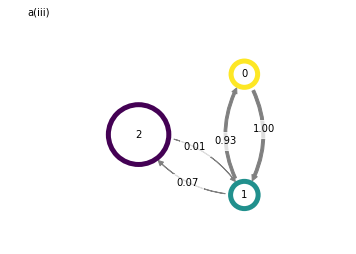

In [44]:
def plot_network(mm, ax, let):
    N = mm.nstates
    # Colors 
    cmap_use = 'viridis_r'
    cmap = matplotlib.cm.get_cmap(cmap_use,N)
    cols = [cmap(n) for n in range(N)]
    
    # Network
    r = 0.8
    x = np.array([r * np.cos(2*np.pi*n/N + np.pi/6) for n in range(N)])
    y = np.array([r * np.sin(2*np.pi*n/N + np.pi/6) for n in range(N)])
    pos = np.concatenate((y[:,np.newaxis], x[:, np.newaxis]), axis=1)
    _, _ = myplt.plot_markov_model(mm.transition_matrix, ax=ax, 
                                  arrow_curvature=3, state_colors=cols,
                                  arrow_label_format = '%2.2f',pos=pos,
                                  figpadding=0.4, arrow_scale=0.5, state_scale=2)
    ax.annotate(s='{}(iii)'.format(let), xy=(0.05, 1.05), xycoords='axes fraction')
    
fig, ax = plt.subplots()
plot_network(bhmms[2], ax, 'a')

In [33]:
print(hmms[1].timescales())
print(msms[1].timescales(k=2))
print(bhmms[1].sample_mean('timescales'))

[ 854.78512031  520.20409973  385.4343021 ]
[ 764.99290625  678.87620182]
[ 7796.3109146   1292.68776482   748.21854085]


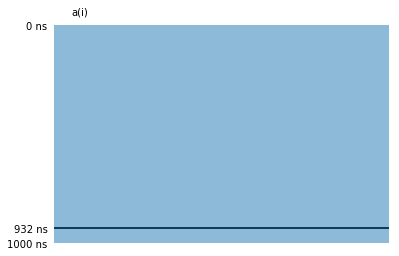

In [43]:
def plot_progress(ax, idx, let):
    TRAJ_LEN=1000
    ax.tick_params(which='both', labelbottom=False,labelleft=True,labeltop=False,labelright=False,
                      bottom=False, left=False, top=False, right=False)
    ax.barh(np.array([idx]), np.array([1]), height=10, zorder=1, color='k')
    ax.barh(np.arange(TRAJ_LEN)+0.5, np.ones(TRAJ_LEN), height=1, zorder=1, alpha=0.5)
    ax.set_xlim(0,1)
    ax.set_ylim(0, TRAJ_LEN)
    ax.invert_yaxis()
    _ = [x.set_visible(False) for x in ax.spines.values()]
    ax.yaxis.set_major_locator(ticker.FixedLocator(locs=[0, idx, TRAJ_LEN]))
    formatter = matplotlib.ticker.StrMethodFormatter('{x} ns')
    ax.yaxis.set_major_formatter(formatter)
#     ax.xaxis.set_tick_params(rotation=45)
    ax.annotate(s='{}(i)'.format(let), xy=(0.05, 1.05), xycoords='axes fraction')

fig, ax = plt.subplots()
plot_progress(ax, 932, let='a')

In [378]:
?plt.barh

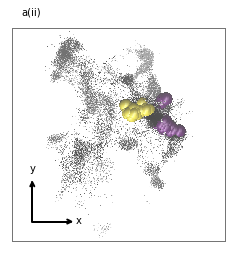

In [42]:
def plot_image(ax, idx, let, coords=['x', 'y']):
    # scatter plot
    img = mpimg.imread('slice_{}_crop.tga'.format(slice_nums[idx][1]))
    ax.imshow(img)
    ax.tick_params(which='both', labelbottom=False,labelleft=False,labeltop=False,labelright=False,
                      bottom=False, left=False, top=False, right=False)
    _ = [x.set_visible(False) for x in ax.spines.values()]
    ax.annotate(s='{}(ii)'.format(let), xy=(0.05, 1.05), xycoords='axes fraction')
#     ax.annotate( s=coords[1], xy=(0.1, 0.1), xytext=(0.1, 0.3),xycoords='axes fraction',textcoords='axes fraction',
#             arrowprops=dict(facecolor='black',arrowstyle='<-', relpos=(0,0)),
#             )
#     ax.annotate( s="x", xy=(0.1, 0.1), xytext=(0.3, 0.1),xycoords='axes fraction',textcoords='axes fraction',
#             arrowprops=dict(arrowstyle='<-', relpos=(0.0, 0.2)),
#             )
    x1, y1 = 0.3, 0.1
    x2, y2 = 0.1, 0.3
    connectionstyle = "angle,angleA=-90,angleB=0,rad=0"
    ax.annotate("",
                xy=(x1, y1), xycoords='axes fraction',
                xytext=(x2, y2), textcoords='axes fraction',
                arrowprops=dict(arrowstyle="<->", color='k',
                                connectionstyle=connectionstyle,lw=2,
                                ))
    ax.annotate(s=coords[0],xy=(x1*1.01, y1*0.9), xycoords='axes fraction')
    ax.annotate(s=coords[1],xy=(x2*0.9, y2*1.1), xycoords='axes fraction')
fig, ax = plt.subplots()
plot_image(ax,0,'a')

# MSM plot 

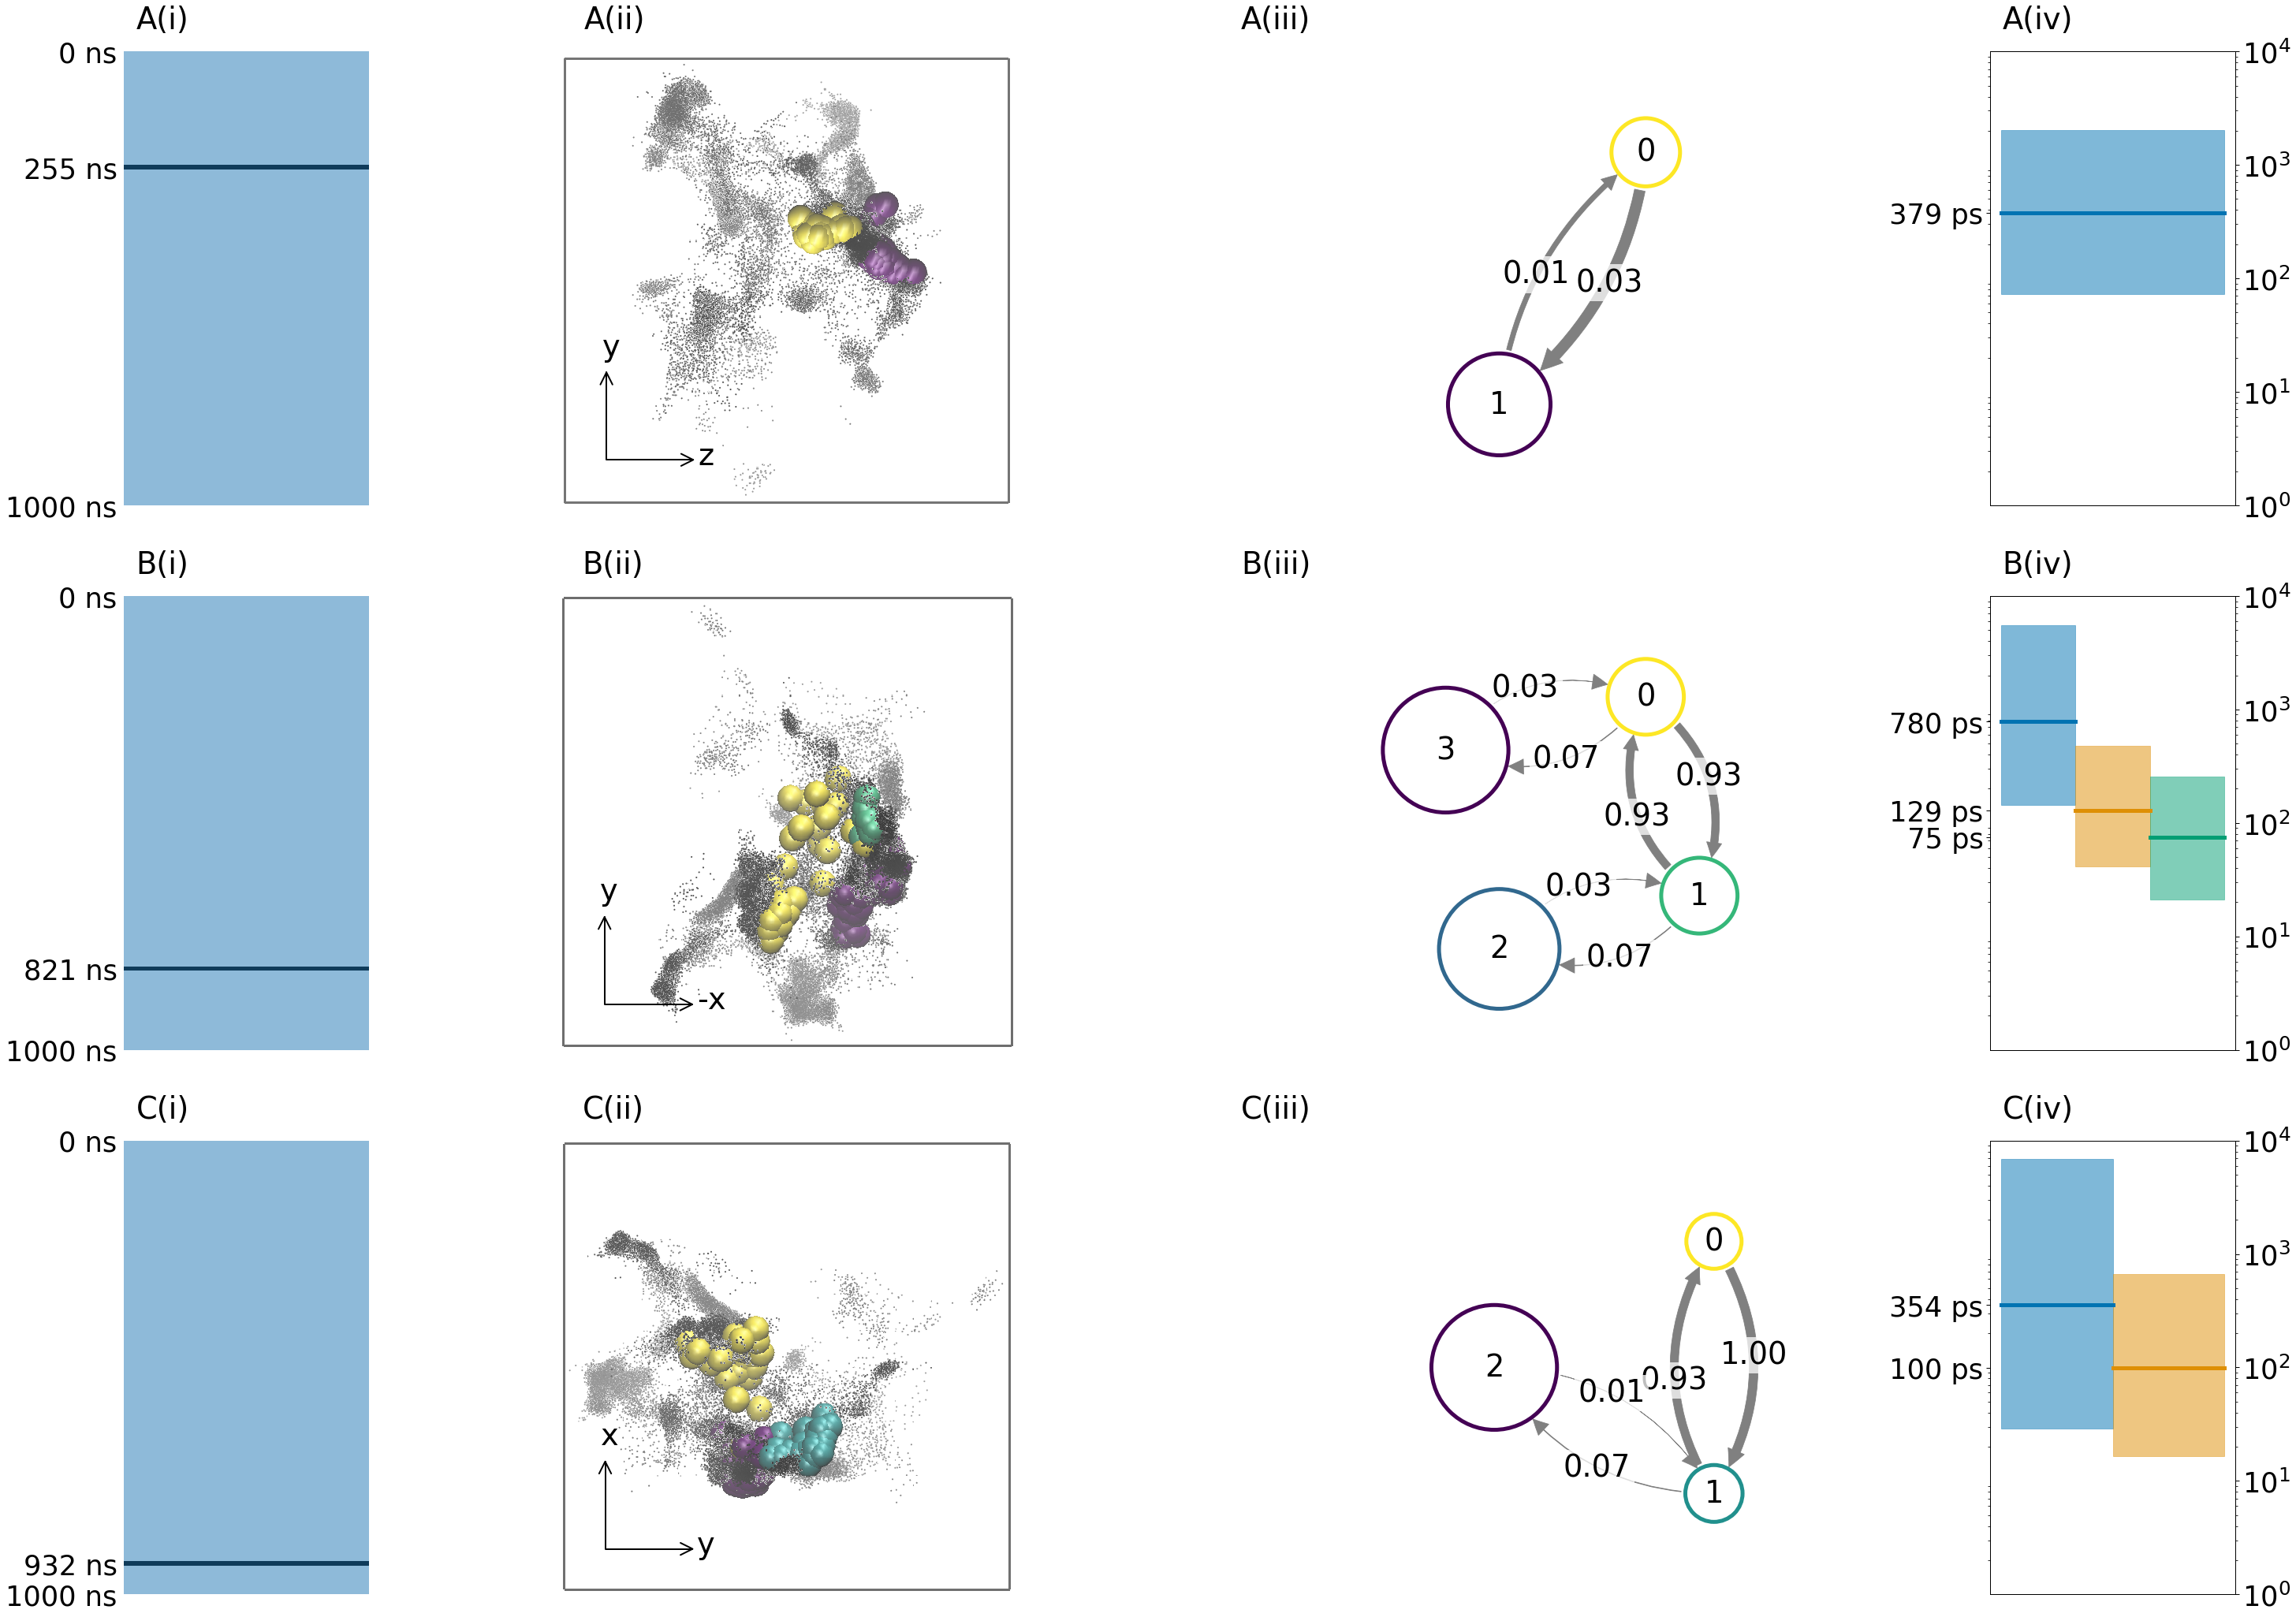

In [54]:
TRAJ_LEN=1000
with sns.plotting_context('paper', font_scale=4):
    scale=4
    ncols=4
    nrows=3
    fig = plt.figure(figsize=(scale*12, scale*3*nrows))

    gs = fig.add_gridspec(nrows, ncols,
                          width_ratios=[1,3,3,1], wspace=0.1,
                          height_ratios=[1,1,1], hspace=0.2)

    for idx in range(3):

        letters = ['A', 'B', 'C']
        coords = [['z', 'y'], ['-x', 'y'], ['y', 'x']]
#         idx = 1
        # Set up figure and axes

        axes = [fig.add_subplot(gs[idx, i]) for i in range(0,ncols)]

        # progress bar
        plot_progress(axes[0], slice_nums[idx][1], letters[idx])

        plot_image(axes[1], idx,  letters[idx], coords=coords[idx])

        # network
        plot_network(bhmms[idx], axes[2], letters[idx])

        # timescales
        plot_timescales(axes[3], bhmms[idx], dt, letters[idx])


    plt.savefig('traj-{0}_slices-{1}-{2}-{3}.png'.format(traj_num, *[slice_nums[i][1] for i in range(3)]), dpi=600)
